In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math

from scipy.stats import wilcoxon

sns.set_style("whitegrid")

### Read in samples for origin ARS316, to set up the annotation of the nucleosome areas

## Wildtype

In [2]:
load_dir =  "ARS316"

In [3]:
ls ARS316/

ARS316_80bp.txt
ARS316_disw2_rep1_780READS_noNA.csv
ARS316_disw2_rep2_780READS_noNA.csv
ARS316_feature_methylation_annotation_v3.csv
ARS316_p_values_avg_feature_methylation.csv
ARS316_pooled_samples_two-sided-test.csv
ARS316_separate_replicates_two-sided-test.csv
DIES6_ALL_REP1_ARS316_end_LexA.txt
DIES6_ARS316_REP2_301READS.csv
Features from ARS316_end_LexA  (31 .. 1280).txt
coordinates_ARS316.txt
coordinates_ARS316_v4.csv
mat_Megalodon_repII_ARS316_end_LexA.txt
plot_data/
plots/
reverse/
unused_files/
wt_mat_Megalodon_repIII_ARS316_end_LexA.txt
wt_mat_Megalodon_repIII_ARS316_end_LexA_301READS.txt


In [4]:
wt_rep3 = np.loadtxt(load_dir + "/wt_mat_Megalodon_repIII_ARS316_end_LexA.txt")

#replicate 2
wt_rep2 = np.loadtxt(load_dir + "/mat_Megalodon_repII_ARS316_end_LexA.txt")

In [5]:
##feature annotation
##anno = pd.read_csv(load_dir + "/Features_from_ARS316_end_LexA _(31 .. 1280).txt", sep  = "\t", 
##                          header = None, index_col = 0)
##anno.columns = ["position", "length"]
##anno = pd.read_csv(load_dir + "/coordinates_ARS316.txt", sep  = "\t", 
##                          header = None, index_col = 0)

##Version 3 of annotation with nucleosome positions and linker
#anno = pd.read_csv(load_dir + "/ARS316_80bp.txt", sep  = "\t", 
#                          header = None, index_col = 0)

##Version 4 of annotation
##anno = pd.read_csv(load_dir + "/coordinates_ARS316_v4.csv", sep  = ",", 
##                          header = None, index_col = 0)
#anno.columns = ["position"]

#anno.index = anno.index.astype("string")
#anno.index = anno.index.str.strip()

#anno["pos_start"] = anno.position.str.split("-").str[0].astype(int) -1
#anno["pos_stop"] = anno.position.str.split("-").str[1].astype(int) -1

#anno["length"] = anno.pos_stop - anno.pos_start

In [36]:
#anno.index

Index(['ns-3', 'L-2', 'ns-2', 'L-1', 'ns-1', 'ARS316', 'ns+1', 'ns+2', 'L+2',
       'ns+3'],
      dtype='object', name=0)

In [35]:
#anno.rename(index = {"+3ns" : "ns+3",
#                   "+2L":"L+2",
#                   "+2ns": "ns+2", 
#                   "+1ns": "ns+1",
#                   "ARS316": "ARS316",
#                   "-1NS": "ns-1",
#                    "-1L" : "L-1",
 #                  "-2NS":"ns-2",
 #                  "-2L":"L-2",
#                   "-3 NS":"ns-3"}, inplace = True)

## An alternative approach to predefined features would be to divide the locus into a number of windows with fixed sizes. Start with a window size of 50 nt and test the effect on clustering

In [149]:
## an alternative approach to predefined features would be to divide the 
#locus into a number of windows with fixed sizes. Start with a window size of 100 nt and 
# test the effect on clustering 

windowsize = 40

d = {"pos_start":list(range(0, wt_rep3.shape[1], windowsize)),
            "pos_stop":list(range((windowsize -1) , wt_rep3.shape[1], windowsize)) + [wt_rep3.shape[1]]}
anno = pd.DataFrame(d,
            index = list(range(1, wt_rep3.shape[1]//windowsize + 2)))
anno["length"] = (anno.pos_stop +1) - anno.pos_start

anno["position"] = "x"

anno.head()

,pos_start,pos_stop,length,position
1,0,39,40,x
2,40,79,40,x
3,80,119,40,x
4,120,159,40,x
5,160,199,40,x


In [126]:
#Load methylation data for the reverse strand:

wt_rep3_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_repIII_ARS316_end_LexA_minus.txt")
wt_rep2_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_repII_ARS316_end_LexA_minus.txt")

dies6_rep1_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_20220126_METHYLATION_DIES6_ALL_REP1_ARS316_end_LexA_minus.txt")
dies6_rep2_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_20220207_DIES6_ALLstrains_meth_REP2_ARS316_end_LexA_minus.txt")

disw2_rep1_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_20211201_all_strains_REP1_disw2_ARS316_end_LexA_minus.txt")
disw2_rep2_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_20220221_disw2_all_meth_REP2_ARS316_end_LexA_minus.txt")

In [8]:
print(wt_rep2.shape[1] == wt_rep3.shape[1])
print(wt_rep3_rev.shape[0] == wt_rep3.shape[0])
print(wt_rep2_rev.shape[0], wt_rep2.shape[0])

True
True
780 819


In [9]:
def subsample(array, n):
    np.random.seed(15)
    idx = np.random.randint(len(array), size=n)
    return array[idx,:]

wt_rep3_join = np.concatenate((wt_rep3, wt_rep3_rev[:, :-1]), axis = 0)
#subsample wt_rep2_rev to 780 reads
wt_rep2_sub = subsample(wt_rep2, 780)
wt_rep2_join = np.concatenate((wt_rep2_sub, wt_rep2_rev[:, :-1]), axis = 0)

wt_rep3 = wt_rep3_join
wt_rep2 = wt_rep2_join

In [10]:
wt_rep2.shape

(1560, 1239)

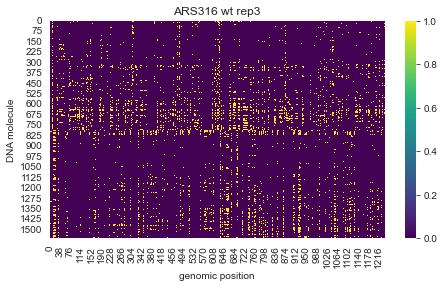

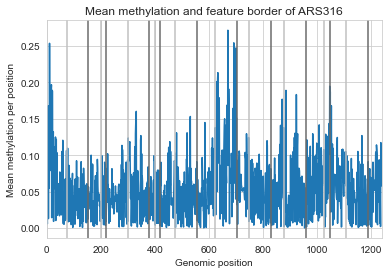

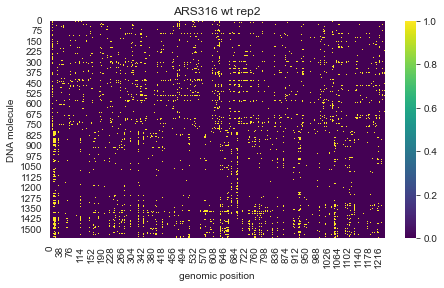

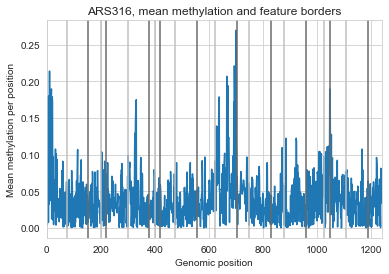

In [11]:
#plot the raw data:
plt.figure(figsize=(7.5,4))
sns.heatmap(wt_rep3, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir + " wt rep3")
plt.show()

#and the bulk data:
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = wt_rep3.mean(axis = 0)
                )
plt.xlabel("Genomic position")
plt.ylabel("Mean methylation per position")
plt.title("Mean methylation and feature border of " + load_dir)
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()

#wildtype replicate 2:
plt.figure(figsize=(7.5,4))
sns.heatmap(wt_rep2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir + " wt rep2")
plt.show()

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = wt_rep2.mean(axis = 0)
                )
plt.xlabel("Genomic position")
plt.ylabel("Mean methylation per position")
plt.title(load_dir + ", mean methylation and feature borders")
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()

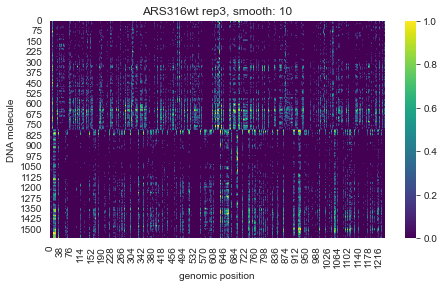

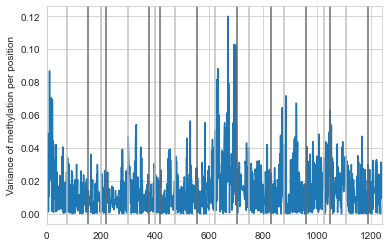

In [12]:
smooth_window = 10

def smooth(array):
        return np.convolve(array, np.ones(smooth_window)/smooth_window, mode = "same")
    
wt_rep3_smooth = np.apply_along_axis(smooth, 0, wt_rep3)
    
plt.figure(figsize=(7.5,4))
sns.heatmap(wt_rep3_smooth, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir + "wt rep3, smooth: " + str(smooth_window))
plt.show()

sns.lineplot(x = range(wt_rep3_smooth.shape[1]), 
                 y = wt_rep3_smooth.std(axis = 0)**2
                )
plt.ylabel("Variance of methylation per position")
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()

In [13]:
#sns.lineplot(x = wt_rep3.shape[1], y = 100 * wt_rep3.cumsum(axis = 0)wt_rep3.cumsum(axis = 0)[wt_rep3.shape[0] -1 , :]/wt_rep3.shape[1])

#wt_rep3.cumsum(axis = 0)[wt_rep3.shape[0] -1 , :].shape
100 * wt_rep3.cumsum(axis = 0)[wt_rep3.shape[0] -1 , :]/wt_rep3.shape[1]

array([ 8.87812752,  1.4527845 ,  0.72639225, ..., 14.76997579,
        7.26392252,  9.28167877])

In [14]:
#this computes the percent of methylation at a specific base
wt_rep3.cumsum(axis = 0)/wt_rep3.shape[1]

#as a measure for the heterogeneity, try the entropy:
# alternatively, try: from scipy.stats import entropy

def entropy(labels, base=None):
    base = 2 if base is None else base
    _ ,counts = np.unique(labels, return_counts=True)
    norm_counts = counts / counts.sum()

    return -(norm_counts * np.log(norm_counts)/np.log(base)).sum()

#https://stackoverflow.com/questions/15450192/fastest-way-to-compute-entropy-in-python

<AxesSubplot:title={'center':'ARS316 wt rep3, entropy per position'}, ylabel='entropy'>

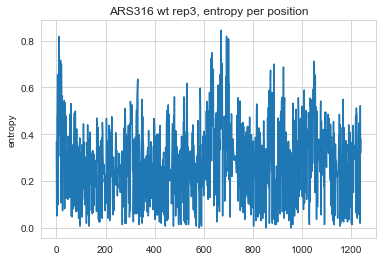

In [15]:
g = sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.apply_along_axis(entropy, 0, wt_rep3))
g.set_ylabel("entropy")
g.set_title(load_dir + " wt rep3, " + "entropy per position")
#g.set_xticks(range(0, ARS305_wt.shape[1], 50))
g

In [16]:
entropy_wt_rep3 = np.apply_along_axis(entropy, 0, wt_rep3)
entropy_wt_rep3.min(), entropy_wt_rep3.max(), np.count_nonzero(entropy_wt_rep3)

(-0.0, 0.8440283903572291, 1236)

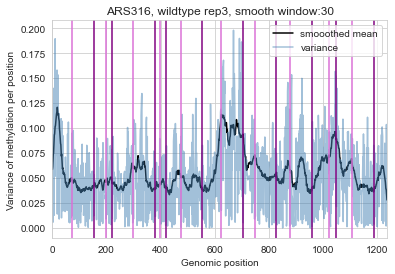

In [17]:
N = 30

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(wt_rep3.mean(axis = 0), np.ones(N)/N, mode ="same"),
             color = "black", label = "smooothed mean")
#plt.ylabel("Mean methylation over sample")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir +  ", wildtype rep3, smooth window:" + str(N))


sns.lineplot(x = range(wt_rep3.shape[1]), 
            y = wt_rep3.std(axis = 0)**2, color = "steelblue", alpha = 0.5,
            label = "variance"
            )
plt.ylabel("Variance of methylation per position")
plt.xlabel("Genomic position")
#plt.axvline(62, color = "purple", label = "border")
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "orchid")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "purple")

## Load data for mutant dies6

In [18]:
dies6_rep1 = np.loadtxt(load_dir + "/DIES6_ALL_REP1_ARS316_end_LexA.txt")
print(dies6_rep1.shape, dies6_rep1_rev.shape)

dies6_rep2 = np.genfromtxt(load_dir + "/DIES6_ARS316_REP2_301READS.csv", dtype = int, delimiter = ",")
print(dies6_rep2.shape, dies6_rep2_rev.shape)

(83, 1239) (93, 1240)
(301, 1239) (274, 1240)


In [19]:
#subsample to equal read counts and join the plus and minus strand
dies6_rep1_rev_sub = subsample(dies6_rep1_rev, 83)
dies6_rep2_sub = subsample(dies6_rep2, 274)

dies6_rep1_join = np.concatenate((dies6_rep1, dies6_rep1_rev_sub[:, :-1]), axis = 0)
dies6_rep2_join = np.concatenate((dies6_rep2_sub, dies6_rep2_rev[:, :-1]), axis = 0)

#rename joined samples to run the rest of the pipeline with it

dies6_rep1 = dies6_rep1_join.copy()
dies6_rep2 = dies6_rep2_join.copy()

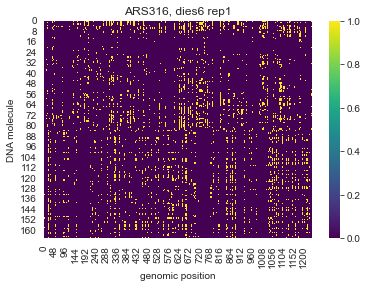

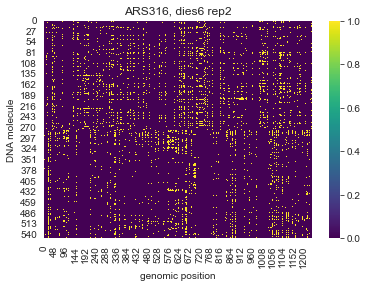

In [20]:
sns.heatmap(dies6_rep1, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, dies6_rep1.shape[1])
plt.title(load_dir + ", dies6 rep1")
plt.show()



sns.heatmap(dies6_rep2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, dies6_rep2.shape[1])
plt.title(load_dir + ", dies6 rep2")
plt.show()

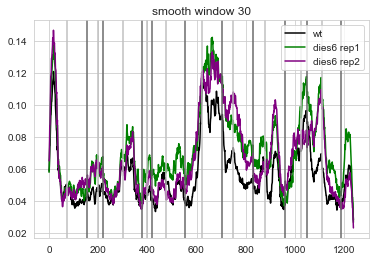

(4969.5, 5.588834065378218e-199)

In [21]:
smooth_window=30

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(wt_rep3.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(dies6_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "green", label = "dies6 rep1")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(dies6_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "purple", label = "dies6 rep2")
plt.title("smooth window " + str(smooth_window))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

wt_rep3_smooth_mean = np.convolve(wt_rep3.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")
dies6_rep1_smooth_mean = np.convolve(dies6_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")
dies6_rep2_smooth_mean = np.convolve(dies6_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")

means = np.concatenate((wt_rep3_smooth_mean.reshape(1, wt_rep3.shape[1]), 
                        dies6_rep1_smooth_mean.reshape(1, wt_rep3.shape[1]),
                        dies6_rep2_smooth_mean.reshape(1, wt_rep3.shape[1])),
                              axis = 0)

from scipy.stats import wilcoxon

w, p = wilcoxon(means[0,:], means[1,:], alternative = "two-sided")
w,p

In [22]:
#statistical test to compare replicates of the mutants: 
wilcoxon(dies6_rep1.mean(axis = 0), 
         dies6_rep2.mean(axis = 0), alternative = "two-sided")

WilcoxonResult(statistic=294432.0, pvalue=2.5221541597681534e-08)

## Load data for mutant disw2

In [23]:
disw2_rep1 = np.genfromtxt(load_dir + "/ARS316_disw2_rep1_780READS_noNA.csv", dtype = int,
                                 delimiter = ",")
print(disw2_rep1.shape, disw2_rep1_rev.shape)


disw2_rep2 = np.genfromtxt(load_dir + "/ARS316_disw2_rep2_780READS_noNA.csv", dtype = int, delimiter = ",")
print(disw2_rep2.shape, disw2_rep2_rev.shape)

(780, 1239) (780, 1240)
(780, 1239) (780, 1240)


In [24]:
#join the plus and minus strand, no subsampling here

disw2_rep1_join = np.concatenate((disw2_rep1, disw2_rep1_rev[:, :-1]), axis = 0)
disw2_rep2_join = np.concatenate((disw2_rep2, disw2_rep2_rev[:, :-1]), axis = 0)

#rename joined samples to run the rest of the pipeline with it

disw2_rep1 = disw2_rep1_join.copy()
disw2_rep2 = disw2_rep2_join.copy()

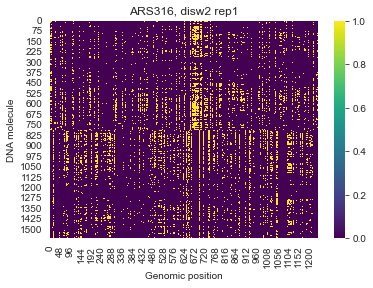

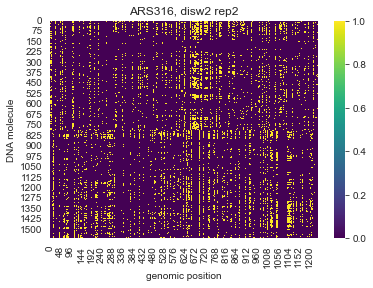

In [25]:
sns.heatmap(disw2_rep1, cmap = "viridis")
plt.xlabel("Genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, disw2_rep1.shape[1])
plt.title(load_dir + ", disw2 rep1")
plt.show()

sns.heatmap(disw2_rep2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, disw2_rep2.shape[1])
plt.title(load_dir + ", disw2 rep2")
plt.show()

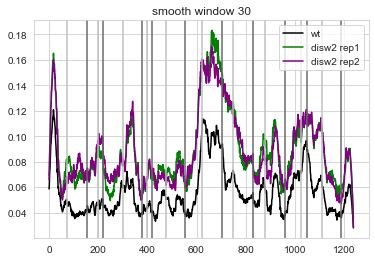

In [26]:
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(wt_rep3.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(disw2_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "green", label = "disw2 rep1")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(disw2_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "purple", label = "disw2 rep2")
plt.title("smooth window " + str(smooth_window))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

In [27]:
#summarise samples
array_dic = {"wt_rep3": wt_rep3_join, 
             "wt_rep2": wt_rep2_join, 
             "dies6_rep1": dies6_rep1_join,
            "dies6_rep2": dies6_rep2_join,
            "disw2_rep1": disw2_rep1_join,
            "disw2_rep2": disw2_rep2_join}

summary=pd.DataFrame()
for element in array_dic.keys():
    summary[element] = pd.DataFrame(array_dic[element].mean(axis=0)).describe()
summary = summary.T
summary["#molecules"] = [array_dic[sample].shape[0] for sample in summary.index]
#summary = summary.T
summary

,count,mean,std,min,25%,50%,75%,max,#molecules
wt_rep3,1239.0,0.056345,0.041711,0.0,0.025641,0.050000,0.078846,0.271795,1560
wt_rep2,1239.0,0.041150,0.034459,0.0,0.016987,0.033974,0.056410,0.269872,1560
dies6_rep1,1239.0,0.071720,0.061113,0.0,0.018072,0.066265,0.102410,0.397590,166
dies6_rep2,1239.0,0.067093,0.057521,0.0,0.014599,0.060219,0.098540,0.354015,548
disw2_rep1,1239.0,0.089074,0.073555,0.0,0.014744,0.084615,0.133013,0.405128,1560
disw2_rep2,1239.0,0.088250,0.070435,0.0,0.022436,0.082051,0.128205,0.397436,1560


### Min-max normalise each experiment and pool replicates

In [28]:
"""wt_rep3_minmax = wt_rep3.mean(axis = 0)/wt_rep3.mean(axis = 0).max()
wt_rep2_minmax = wt_rep2.mean(axis = 0)/wt_rep2.mean(axis = 0).max()

pooled_wt = np.concatenate((wt_rep3_minmax.reshape(1, -1), wt_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#dies6
dies6_rep1_minmax = dies6_rep1.mean(axis = 0)/dies6_rep1.mean(axis = 0).max()
dies6_rep2_minmax = dies6_rep2.mean(axis = 0)/dies6_rep2.mean(axis = 0).max()

pooled_dies6 = np.concatenate((dies6_rep1_minmax.reshape(1, -1), dies6_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#disw2
disw2_rep1_minmax = disw2_rep1.mean(axis = 0)/disw2_rep1.mean(axis = 0).max()
disw2_rep2_minmax = disw2_rep2.mean(axis = 0)/disw2_rep2.mean(axis = 0).max()

pooled_disw2 = np.concatenate((disw2_rep1_minmax.reshape(1, -1), disw2_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)"""


#normalise to the nucleosomal array spike-ins
mean_array_wt_rep3 = 0.048283
mean_array_wt_rep2 = 0.034160
mean_array_dies6_rep1=0.050732
mean_array_dies6_rep2 = 0.045048
mean_array_disw2_rep1 = 0.061350
mean_array_disw2_rep2 = 0.059359

wt_rep3_minmax = wt_rep3.mean(axis = 0)/mean_array_wt_rep3
wt_rep2_minmax = wt_rep2.mean(axis = 0)/mean_array_wt_rep2

pooled_wt = np.concatenate((wt_rep3_minmax.reshape(1, -1), wt_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#dies6
dies6_rep1_minmax = dies6_rep1.mean(axis = 0)/mean_array_dies6_rep1
dies6_rep2_minmax = dies6_rep2.mean(axis = 0)/mean_array_dies6_rep2

pooled_dies6 = np.concatenate((dies6_rep1_minmax.reshape(1, -1), dies6_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#disw2
disw2_rep1_minmax = disw2_rep1.mean(axis = 0)/mean_array_disw2_rep1
disw2_rep2_minmax = disw2_rep2.mean(axis = 0)/mean_array_disw2_rep2

pooled_disw2 = np.concatenate((disw2_rep1_minmax.reshape(1, -1), disw2_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

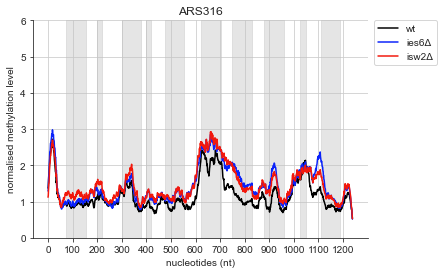

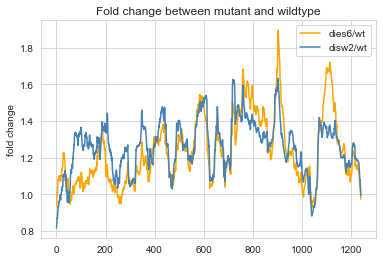

In [30]:
N=30

with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False}):
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_wt, np.ones(N)/N, mode="same"), #wt_min_max
             color = "black", 
            label = "wt")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same"), #dies6_min_max
             color = "#0a22fa",# alpha = 0.7,
            label = "ies6Δ")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
            y = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same"), #disw2_min_max
            color = "#f2180c",# alpha = 0.7,
            label = "isw2Δ")
        plt.title(load_dir 
          #+  ", mean normalised and pooled, smoothened with " + str(N)
                  )
        for feature in anno.index:
            plt.fill_betweenx(range(0,7), 
                      anno.loc[feature, "pos_start"],
                      anno.loc[feature, "pos_stop"], 
                      color = "silver", alpha = 0.4)
        plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
        plt.ylim(0, 6)
        plt.xticks(range(0, wt_rep3_minmax.shape[0], 100))
        plt.xlabel("nucleotides (nt)")
        plt.ylabel("normalised methylation level")
        #plt.savefig(load_dir + "/plots/ARS316_smoothed_profiles_wt_mut_revision.pdf", dpi=300, bbox_inches = "tight")
        plt.show()

sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
            color = "orange", 
             label = "dies6/wt")
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_disw2, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
            color = "steelblue",
             label = "disw2/wt")
plt.ylabel("fold change")
plt.title("Fold change between mutant and wildtype")
plt.show()

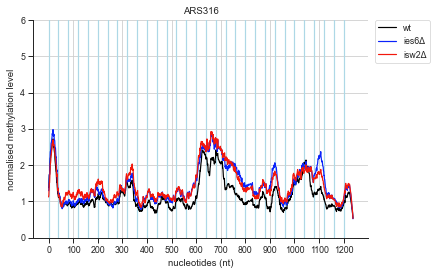

In [150]:
#For the fixed window sizes, plot the smoothened tracks and the start of each window
sns.set_context("paper")
with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False, 
                             "font_scale": 0.6}):
        for left_border in anno.loc[:, "pos_start"]:
            plt.axvline(left_border, color = "lightblue")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
             color = "black", 
            label = "wt")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same"), 
             color = "#0a22fa",# alpha = 0.7,
            label = "ies6Δ")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
            y = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same"), 
            color = "#f2180c",# alpha = 0.7,
            label = "isw2Δ")
        plt.title(load_dir 
          #+  ", mean normalised and pooled, smoothened with " + str(N)
                  )
        plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
        plt.ylim(0, 6)
        plt.xticks(range(0, wt_rep3_minmax.shape[0], 100))
        plt.xlabel("nucleotides (nt)")
        plt.ylabel("normalised methylation level")
        #plt.savefig(load_dir + "/plots/ARS313_smoothed_profiles_revision_window50.pdf", dpi=300, bbox_inches = "tight")
        plt.show()

## Condense segment information for statistical testing of methylation per feature window for pooled replicates

In [151]:
segments = anno.drop(columns = "position")

#list comprehension to catch the pooled methylation values per sample in a cell per column
array_list = [pooled_wt[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["wt_mean"] = pd.Series(array_list, index = segments.index)

#dies6 mutant 
array_list = [pooled_dies6[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["dies6_mean"] = pd.Series(array_list, index = segments.index)

#disw2 mutant

array_list = [pooled_disw2[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["disw2_mean"] = pd.Series(array_list, index = segments.index)

In [152]:
segments["p_value_dies6"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"dies6_mean"],
                                                alternative = "two-sided").pvalue for index in segments.index]

segments["p_value_disw2"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"disw2_mean"],
                                                alternative = "two-sided").pvalue for index in segments.index]
segments.drop(segments.columns[3:6], axis =1, inplace = True)

In [153]:
segments.head(n=15)
#segments.to_csv(load_dir + "/ARS316_pooled_samples_two-sided-test.csv")

,pos_start,pos_stop,length,p_value_dies6,p_value_disw2
1,0,39,40,0.459534,7.694801e-01
2,40,79,40,0.308338,3.217809e-01
3,80,119,40,0.502960,1.772500e-03
4,120,159,40,0.142846,6.962172e-04
5,160,199,40,0.008702,4.415838e-03
6,200,239,40,0.033908,5.970974e-04
7,240,279,40,0.295273,9.401279e-02
8,280,319,40,0.036327,1.460110e-02
9,320,359,40,0.000597,5.065919e-07
10,360,399,40,0.076347,7.689575e-03


In [155]:
#Regions significant for dies6:
pvalue = 2.5e-2

print("       Which sites have a different mean methylation mutants compared to wildtype?")
print("       P-value below: ", pvalue)
significant = segments.loc[(segments["p_value_dies6"] < pvalue) & (segments["p_value_disw2"] < pvalue)]
significant

       Which sites have a different mean methylation mutants compared to wildtype?
       P-value below:  0.025


,pos_start,pos_stop,length,p_value_dies6,p_value_disw2
5,160,199,40,8.702133e-03,4.415838e-03
9,320,359,40,5.970974e-04,5.065919e-07
11,400,439,40,2.832897e-05,1.176654e-05
13,480,519,40,1.948252e-03,1.147919e-03
14,520,559,40,7.074548e-03,7.074548e-03
15,560,599,40,4.888299e-05,3.012169e-05
17,640,679,40,1.858468e-03,1.463934e-03
18,680,719,40,1.109128e-02,2.954674e-03
19,720,759,40,4.888299e-05,6.973902e-05
20,760,799,40,1.945544e-04,5.507059e-05


In [156]:
##Regions significant for disw2:
#print("       Which sites have a different mean methylation in the disw2 mutant?")
#print("       P-value below: ", pvalue)
#segments.loc[(segments["p_value_disw2"] < pvalue)]

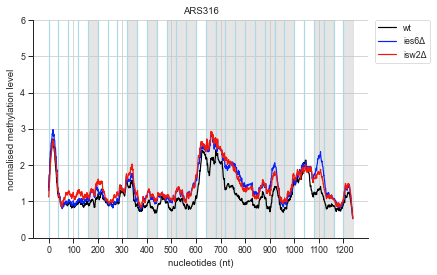

In [157]:
sns.set_context("paper")
with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False}):
        for left_border in anno.loc[:, "pos_start"]:
            plt.axvline(left_border, color = "lightblue")
        for feature in significant.index:
            plt.fill_betweenx(range(0,7), 
                      significant.loc[feature, "pos_start"],
                      significant.loc[feature, "pos_stop"], 
                      color = "silver", alpha = 0.4)
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
             color = "black", 
            label = "wt")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same"), 
             color = "#0a22fa",# alpha = 0.7,
            label = "ies6Δ")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
            y = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same"), 
            color = "#f2180c",# alpha = 0.7,
            label = "isw2Δ")
        plt.title(load_dir 
          #+  ", mean normalised and pooled, smoothened with " + str(N)
                  )
        plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
        plt.ylim(0, 6)
        plt.xticks(range(0, wt_rep3_minmax.shape[0], 100))
        plt.xlabel("nucleotides (nt)")
        plt.ylabel("normalised methylation level")
        #plt.savefig(load_dir + "/plots/ARS313_smoothed_profiles_revision_window100_selection.pdf", dpi=300, bbox_inches = "tight")
        plt.show()

### Compare pooled wildtype to mutant replicates separately and perform statistical test, then filter regions

In [132]:
segments = anno.drop(columns = "position")

#list comprehension to catch the pooled methylation values per sample in a cell per column
array_list = [pooled_wt[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["wt_mean"] = pd.Series(array_list, index = segments.index)

#dies6 mutant 
array_list = [dies6_rep1_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["dies6_mean_rep1"] = pd.Series(array_list, index = segments.index)

array_list = [dies6_rep2_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["dies6_mean_rep2"] = pd.Series(array_list, index = segments.index)


#disw2 mutant
array_list = [disw2_rep1_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["disw2_mean_rep1"] = pd.Series(array_list, index = segments.index)

array_list = [disw2_rep2_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["disw2_mean_rep2"] = pd.Series(array_list, index = segments.index)

In [133]:
#perform statistical test
segments["p_value_dies6_rep1"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"dies6_mean_rep1"],
                                                alternative = "two-sided").pvalue for index in segments.index]
segments["p_value_dies6_rep2"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"dies6_mean_rep2"],
                                                alternative = "two-sided").pvalue for index in segments.index]

segments["p_value_disw2_rep1"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"disw2_mean_rep1"],
                                                alternative = "two-sided").pvalue for index in segments.index]
segments["p_value_disw2_rep2"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"disw2_mean_rep2"],
                                                alternative = "two-sided").pvalue for index in segments.index]
test_higher = segments.iloc[:, :8]
segments.drop(segments.columns[3:8], axis =1, inplace = True)

In [134]:
segments
#segments.to_csv(load_dir + "/ARS316_separate_replicates_two-sided-test.csv")

,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
1,0,29,30,0.642004,0.055664,0.905333,0.888225
2,30,59,30,0.190804,0.213745,0.314666,0.673279
3,60,89,30,0.552085,0.122090,0.000191,0.003390
4,90,119,30,0.770346,0.358089,0.050359,0.045484
5,120,149,30,0.468834,0.007101,0.001781,0.000714
6,150,179,30,0.611341,0.012508,0.007575,0.002947
7,180,209,30,0.028181,0.005460,0.008077,0.001916
8,210,239,30,0.642004,0.009171,0.116955,0.000714
9,240,269,30,0.673270,0.974125,0.523549,0.008609
10,270,299,30,0.939673,0.070991,0.015909,0.001426


In [94]:
#Regions significant for dies6:
pvalue = 2.5e-2

print("       Which sites have a different mean methylation in the dies6 mutant?")
print("       P-value below: ", pvalue)
segments.loc[(segments["p_value_dies6_rep1"] < pvalue) &
            (segments["p_value_dies6_rep2"] < pvalue)]

       Which sites have a different mean methylation in the dies6 mutant?
       P-value below:  0.025


,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
12,330,359,30,0.008077,0.001053,0.000046,0.000004
14,390,419,30,0.001226,0.000407,0.000046,0.000042
15,420,449,30,0.001536,0.003390,0.000442,0.000079
20,570,599,30,0.000382,0.000021,0.000061,0.000021
25,720,749,30,0.014119,0.000161,0.002947,0.000714
26,750,779,30,0.005460,0.000161,0.000407,0.000247
27,780,809,30,0.001654,0.000519,0.000345,0.000087
28,810,839,30,0.001053,0.000247,0.000563,0.000407
29,840,869,30,0.000660,0.000714,0.000292,0.000135
30,870,899,30,0.002558,0.000519,0.001053,0.000773


In [95]:
#Regions significant for disw2:
pvalue = 2.5e-2

print("       Which sites have a different mean methylation in the disw2 mutant?")
print("       P-value below: ", pvalue)
segments.loc[(segments["p_value_disw2_rep1"] < pvalue) &
            (segments["p_value_disw2_rep2"] < pvalue)]

       Which sites have a different mean methylation in the disw2 mutant?
       P-value below:  0.025


,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
3,60,89,30,0.552085,0.122090,0.000191,0.003390
5,120,149,30,0.468834,0.007101,0.001781,0.000714
6,150,179,30,0.611341,0.012508,0.007575,0.002947
7,180,209,30,0.028181,0.005460,0.008077,0.001916
10,270,299,30,0.939673,0.070991,0.015909,0.001426
12,330,359,30,0.008077,0.001053,0.000046,0.000004
14,390,419,30,0.001226,0.000407,0.000046,0.000042
15,420,449,30,0.001536,0.003390,0.000442,0.000079
17,480,509,30,0.004463,0.025221,0.004169,0.000345
18,510,539,30,0.002381,0.038922,0.005460,0.005460


In [96]:
#Repeat this test for the case that methylation in one fragment is higher than in wildtype:

test_higher["p_value_dies6_rep1"] = [wilcoxon(test_higher.loc[index, "wt_mean"], 
                                           test_higher.loc[index,"dies6_mean_rep1"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher["p_value_dies6_rep2"] = [wilcoxon(test_higher.loc[index, "wt_mean"], 
                                           test_higher.loc[index,"dies6_mean_rep2"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher["p_value_disw2_rep1"] = [wilcoxon(test_higher.loc[index, "wt_mean"], 
                                           test_higher.loc[index,"disw2_mean_rep1"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher["p_value_disw2_rep2"] = [wilcoxon(test_higher.loc[index, "wt_mean"], 
                                           test_higher.loc[index,"disw2_mean_rep2"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher.drop(test_higher.columns[3:8], axis =1, inplace = True)

In [97]:
test_higher

,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
1,0,29,30,0.678998,0.027832,0.452666,0.444112
2,30,59,30,0.904598,0.893128,0.842667,0.663361
3,60,89,30,0.723957,0.061045,0.000096,0.001695
4,90,119,30,0.385173,0.179044,0.025180,0.022742
5,120,149,30,0.765583,0.003550,0.000890,0.000357
6,150,179,30,0.305671,0.006254,0.003787,0.001474
7,180,209,30,0.014091,0.002730,0.004038,0.000958
8,210,239,30,0.678998,0.004586,0.058478,0.000357
9,240,269,30,0.663365,0.487063,0.738226,0.004304
10,270,299,30,0.469836,0.035495,0.007955,0.000713


In [98]:
#Regions significant for dies6:
pvalue = 2.5e-2

print("       Which sites have a higher mean methylation for the dies6 mutant?")
test_higher.loc[(test_higher["p_value_dies6_rep1"] < pvalue) & 
         (test_higher["p_value_dies6_rep2"] < pvalue)]

       Which sites have a higher mean methylation for the dies6 mutant?


,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
7,180,209,30,0.014091,0.002730,0.004038,0.000958
12,330,359,30,0.004038,0.000527,0.000023,0.000002
14,390,419,30,0.000613,0.000204,0.000023,0.000021
15,420,449,30,0.000768,0.001695,0.000221,0.000040
17,480,509,30,0.002231,0.012610,0.002085,0.000173
18,510,539,30,0.001191,0.019461,0.002730,0.002730
20,570,599,30,0.000191,0.000011,0.000031,0.000011
22,630,659,30,0.020507,0.013333,0.022742,0.014091
23,660,689,30,0.019461,0.011922,0.012610,0.010050
25,720,749,30,0.007059,0.000081,0.001474,0.000357


In [99]:
#Regions significant for disw2:
pvalue = 2.5e-2

print("       Which sites have a higher mean methylation for the disw2 mutant?")
test_higher.loc[(test_higher["p_value_disw2_rep1"] < pvalue) & 
         (test_higher["p_value_disw2_rep2"] < pvalue)]

       Which sites have a higher mean methylation for the disw2 mutant?


,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
3,60,89,30,0.723957,0.061045,0.000096,0.001695
5,120,149,30,0.765583,0.003550,0.000890,0.000357
6,150,179,30,0.305671,0.006254,0.003787,0.001474
7,180,209,30,0.014091,0.002730,0.004038,0.000958
10,270,299,30,0.469836,0.035495,0.007955,0.000713
12,330,359,30,0.004038,0.000527,0.000023,0.000002
14,390,419,30,0.000613,0.000204,0.000023,0.000021
15,420,449,30,0.000768,0.001695,0.000221,0.000040
17,480,509,30,0.002231,0.012610,0.002085,0.000173
18,510,539,30,0.001191,0.019461,0.002730,0.002730


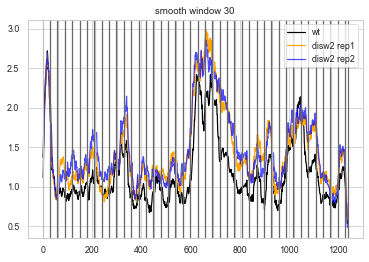

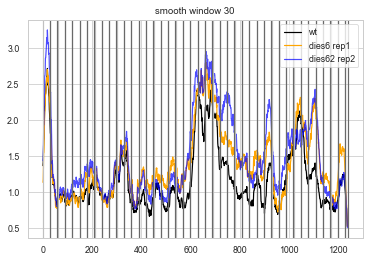

In [105]:
# How does that look over the whole sequence?
smooth_width = 30

sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(pooled_wt, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(disw2_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "orange", label = "disw2 rep1")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(disw2_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "blue", alpha = 0.7, label = "disw2 rep2")
plt.title("smooth window " + str(smooth_width))
#plt.xlim(600,700)
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(pooled_wt, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(dies6_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "orange", label = "dies6 rep1")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(dies6_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "blue", alpha = 0.7, label = "dies62 rep2")
plt.title("smooth window " + str(smooth_width))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

In [39]:
#Display the mean methylation per feature

def condense_features(array, anno):
    output = np.empty(array.shape[0],)
    for index in anno.index:
        feature_array = array[:, anno.loc[index, "pos_start"]: anno.loc[index, "pos_stop"]]
        means_by_feature = np.apply_along_axis(np.mean, 1, feature_array)
        #means_by_feature = np.apply_along_axis(np.std, 1, feature_array) #to calculate variance
        output = np.column_stack((output, means_by_feature))
    return output[:, 1:]

def max_normalise_array(array):
    return array/array.mean(axis=0).max()


In [136]:
#20230214: for the fixed window size approach, only select significantly different regions
saved = anno.copy()
anno = anno.iloc[anno.index.intersection(significant.index),:]

In [122]:
#try the mean methylation on smoothed data per window

"""
smooth_window = 10

def smooth(array):
        return np.convolve(array, np.ones(smooth_window)/smooth_window, mode = "same")
    
wt_rep3_smooth = np.apply_along_axis(smooth, 0, wt_rep3)
dies6_rep2_smooth = np.apply_along_axis(smooth, 0, dies6_rep2)
disw2_rep1_smooth = np.apply_along_axis(smooth, 0, disw2_rep1)

wt_rep3_feat_me = condense_features(wt_rep3_smooth, anno)
dies6_rep2_feat_me = condense_features(dies6_rep2_smooth, anno)
disw2_rep1_feat_me = condense_features(disw2_rep1_smooth, anno)
"""

'\nsmooth_window = 10\n\ndef smooth(array):\n        return np.convolve(array, np.ones(smooth_window)/smooth_window, mode = "same")\n    \nwt_rep3_smooth = np.apply_along_axis(smooth, 0, wt_rep3)\ndies6_rep2_smooth = np.apply_along_axis(smooth, 0, dies6_rep2)\ndisw2_rep1_smooth = np.apply_along_axis(smooth, 0, disw2_rep1)\n\nwt_rep3_feat_me = condense_features(wt_rep3_smooth, anno)\ndies6_rep2_feat_me = condense_features(dies6_rep2_smooth, anno)\ndisw2_rep1_feat_me = condense_features(disw2_rep1_smooth, anno)\n'

In [137]:
"""#normalize the count matrices to the max of averages of the respective sample
wt_rep3_maxnorm = max_normalise_array(wt_rep3)
wt_rep2_maxnorm = max_normalise_array(wt_rep2)

dies6_rep1_maxnorm = max_normalise_array(dies6_rep1)
dies6_rep2_maxnorm = max_normalise_array(dies6_rep2)

disw2_rep1_maxnorm = max_normalise_array(disw2_rep1)
disw2_rep2_maxnorm = max_normalise_array(disw2_rep2)
"""

#normalise the count matrices to the mean methylation frequency of the nucleosomal array spike-in controls

#normalise to the nucleosomal array spike-ins

wt_rep3_maxnorm = wt_rep3/mean_array_wt_rep3
wt_rep2_maxnorm = wt_rep2/mean_array_wt_rep2

dies6_rep1_maxnorm = dies6_rep1/mean_array_dies6_rep1
dies6_rep2_maxnorm = dies6_rep2/mean_array_dies6_rep2

disw2_rep1_maxnorm = disw2_rep1/mean_array_disw2_rep1
disw2_rep2_maxnorm = disw2_rep2/mean_array_disw2_rep2

#condense methylation by feature 
wt_rep3_feat_me = condense_features(wt_rep3_maxnorm, anno)
wt_rep2_feat_me = condense_features(wt_rep2_maxnorm, anno)

wt_pool = np.concatenate((wt_rep3_feat_me, wt_rep2_feat_me), axis = 0)

dies6_rep1_feat_me = condense_features(dies6_rep1_maxnorm, anno)
dies6_rep2_feat_me = condense_features(dies6_rep2_maxnorm, anno)

dies6_pool = np.concatenate((dies6_rep1_feat_me, dies6_rep2_feat_me), axis= 0)

disw2_rep1_feat_me = condense_features(disw2_rep1_maxnorm, anno)
disw2_rep2_feat_me = condense_features(disw2_rep2_maxnorm, anno)

disw2_pool = np.concatenate((disw2_rep1_feat_me, disw2_rep2_feat_me), axis = 0)

Comparing replicates


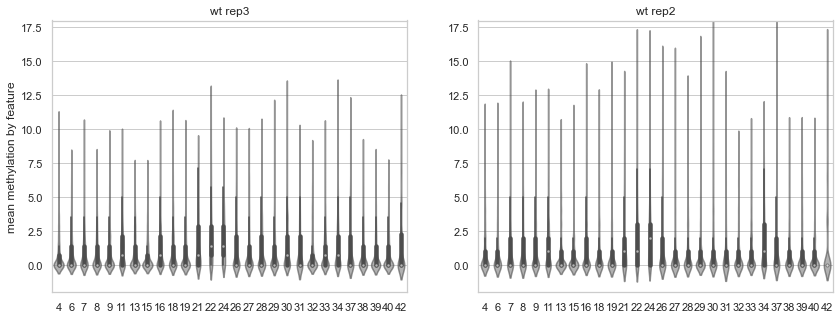

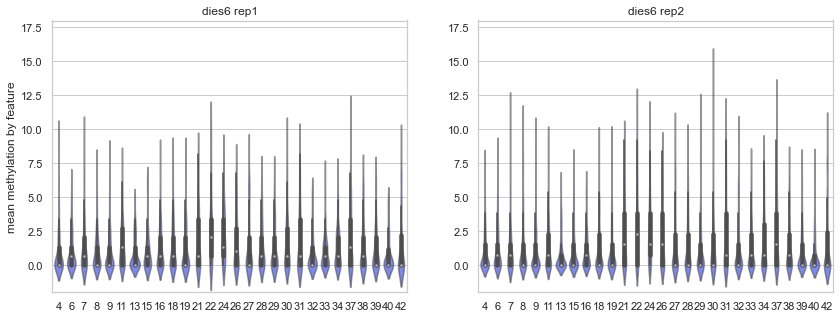

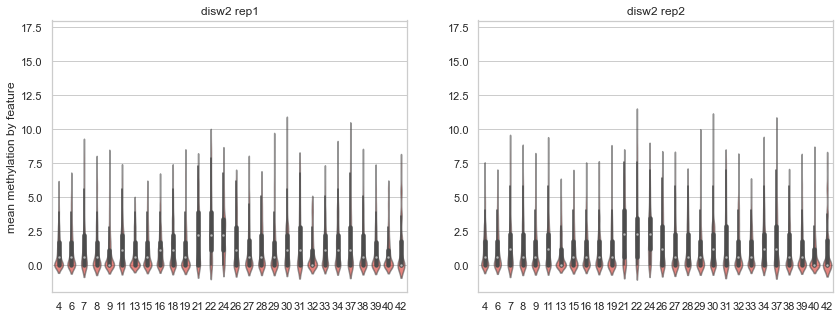

In [138]:
sns.set(font_scale=1)
sns.set_style("whitegrid")

print("Comparing replicates")
#wt
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,5))

sns.violinplot(data = wt_rep3_feat_me, axis = 1, color = "grey", ax=ax1)
ax1.set_title("wt rep3")
ax1.set_xticklabels(anno.index)
ax1.set_ylim(-2,18)
ax1.set_ylabel("mean methylation by feature")
plt.setp(ax1.collections, alpha = 0.6)

sns.violinplot(data = wt_rep2_feat_me, axis = 1, color = "grey", ax=ax2)
ax2.set_title("wt rep2")
ax2.set_xticklabels(anno.index)
ax2.set_ylim(-2,18)
plt.setp(ax2.collections, alpha = 0.6)
#plt.savefig(load_dir + "/plots/ARS316_methylyation_by_feature_wt.tif")
plt.show()

#dies6
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,5))
sns.violinplot(data = dies6_rep1_feat_me, axis = 1, color = "#0a22fa", ax=ax1)
ax1.set_title("dies6 rep1")
ax1.set_xticklabels(anno.index)
ax1.set_ylim(-2,18)
ax1.set_ylabel("mean methylation by feature")
plt.setp(ax1.collections, alpha = 0.6)

sns.violinplot(data = dies6_rep2_feat_me, axis = 1, color = "#0a22fa", ax=ax2)
ax2.set_title("dies6 rep2")
ax2.set_xticklabels(anno.index)
ax2.set_ylim(-2,18)
plt.setp(ax2.collections, alpha = 0.6)
#plt.savefig(load_dir + "/plots/ARS316_methylyation_by_feature_dies6.tif")
plt.show()

#disw2
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,5))
sns.violinplot(data = disw2_rep1_feat_me, axis = 1, color = "#f2180c", ax=ax1)
ax1.set_title("disw2 rep1")
ax1.set_xticklabels(anno.index)
ax1.set_ylim(-2,18)
ax1.set_ylabel("mean methylation by feature")
plt.setp(ax1.collections, alpha = 0.6)

sns.violinplot(data = disw2_rep2_feat_me, axis = 1, color = "#f2180c", ax=ax2)
ax2.set_title("disw2 rep2")
ax2.set_xticklabels(anno.index)
ax2.set_ylim(-2,18)
plt.setp(ax2.collections, alpha = 0.6)
#plt.savefig(load_dir + "/plots/ARS316_methylyation_by_feature_disw2.tif")
plt.show()

In [139]:
#Combine the violinplots into one plot per replicate:
#for each feature, plot wt and mutants next to each other

#transfer array to dataframe, melt that into the long form and assign a catergory "condition"
feat_me_wt_rep3 = pd.DataFrame(wt_rep3_feat_me, columns = anno.index)
feat_me_wt_rep3["molecule"] = feat_me_wt_rep3.index
feat_me_wt_rep3_melt = pd.melt(feat_me_wt_rep3, id_vars=("molecule"), var_name = ("feature"))
feat_me_wt_rep3_melt["condition"] = "wt rep3"

feat_me_wt_pool = pd.DataFrame(wt_pool, columns = anno.index)
feat_me_wt_pool["molecule"] = feat_me_wt_pool.index
feat_me_wt_melt = pd.melt(feat_me_wt_pool, id_vars=("molecule"), var_name = ("feature"))
feat_me_wt_melt["condition"] = "wt"


#the same for dies6
feat_me_dies6_rep2 = pd.DataFrame(dies6_rep2_feat_me, columns = anno.index)
feat_me_dies6_rep2["molecule"] = feat_me_dies6_rep2.index

feat_me_dies6_rep2_melt = pd.melt(feat_me_dies6_rep2, id_vars=("molecule"), var_name = ("feature"))
feat_me_dies6_rep2_melt["condition"] = "ies6Δ"

feat_me_dies6_pool = pd.DataFrame(dies6_pool, columns = anno.index)
feat_me_dies6_pool["molecule"] = feat_me_dies6_pool.index
feat_me_dies6_melt = pd.melt(feat_me_dies6_pool, id_vars=("molecule"), var_name = ("feature"))
feat_me_dies6_melt["condition"] = "ies6Δ"

#the same for disw2
feat_me_disw2_rep1 = pd.DataFrame(disw2_rep1_feat_me, columns = anno.index)
feat_me_disw2_rep1["molecule"] = feat_me_disw2_rep1.index

feat_me_disw2_rep1_melt = pd.melt(feat_me_disw2_rep1, id_vars=("molecule"), var_name = ("feature"))
feat_me_disw2_rep1_melt["condition"] = "isw2Δ"

feat_me_disw2_pool = pd.DataFrame(disw2_pool, columns = anno.index)
feat_me_disw2_pool["molecule"] = feat_me_disw2_pool.index
feat_me_disw2_melt = pd.melt(feat_me_disw2_pool, id_vars=("molecule"), var_name = ("feature"))
feat_me_disw2_melt["condition"] = "isw2Δ"

#merge into one dataframe:
methylation_rep1 = pd.concat([feat_me_wt_melt, feat_me_dies6_melt, feat_me_disw2_melt])
methylation_rep1.rename(columns = {"value" : "norm methylation"}, inplace=True)

In [140]:
sns.set_context("paper")

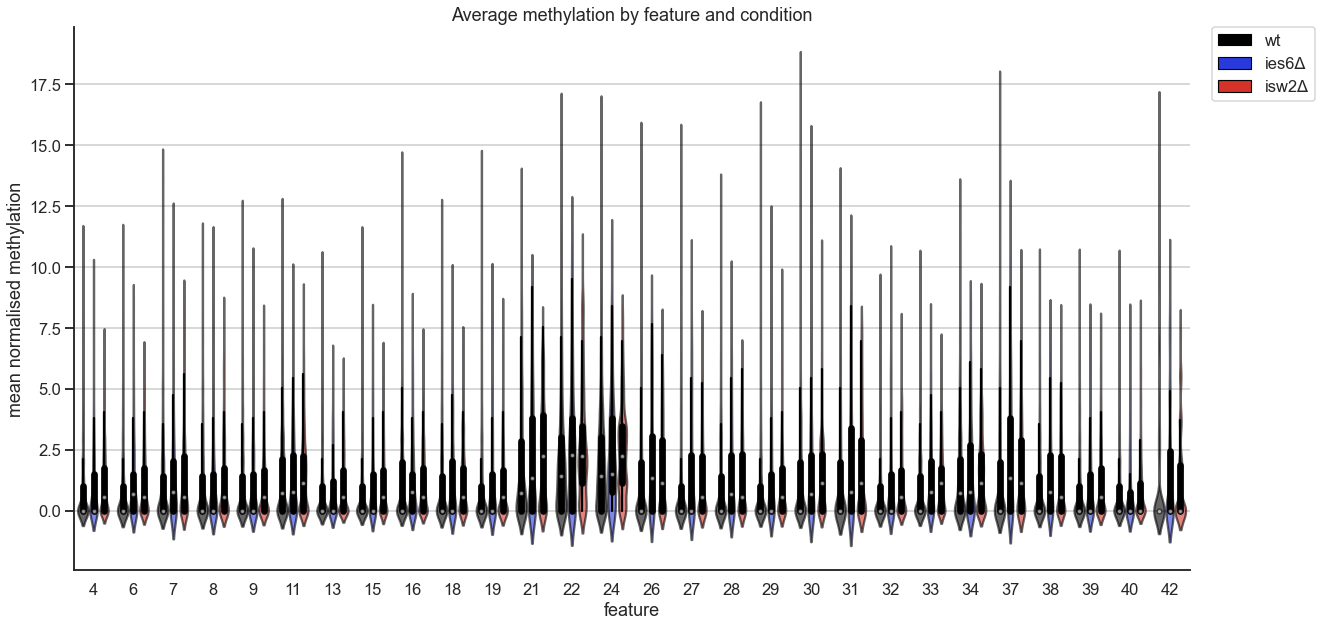

In [141]:
col_Anna = ["black", "#0a22fa", "#f2180c"]

with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False,
                                 'xtick.bottom': False}):
    sns.set_context("talk")
    plt.figure(figsize = (20,10)) #10,7
    ax = sns.violinplot(data = methylation_rep1, x="feature", y = "norm methylation", hue = "condition", 
                    palette = col_Anna)
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
    plt.setp(ax.collections, alpha = 0.6)
    plt.title("Average methylation by feature and condition")
    plt.ylabel("mean normalised methylation")
    #plt.savefig(load_dir + "/plots/ARS316_pooled_norm_av_methylation_by_feature_anno4_revision.pdf", 
     #           dpi = 300, bbox_inches = "tight")
    plt.show()

In [58]:
#methylation_rep1.to_csv(load_dir + "/ARS316_violinplots_annotation_v3.csv")

In [142]:
#Combine the violinplots into one plot per replicate:
#for each feature, plot wt and mutants next to each other

#transfer array to dataframe, melt that into the long form and assign a catergory "condition"
feat_me_wt_rep3 = pd.DataFrame(wt_rep3_feat_me, columns = anno.index)
feat_me_wt_rep3["molecule"] = feat_me_wt_rep3.index
feat_me_wt_rep3["strand"] = ["plus" if i<feat_me_wt_rep3.shape[0]//2 else "minus" for i in range(feat_me_wt_rep3.shape[0])]
feat_me_wt_rep3_melt = pd.melt(feat_me_wt_rep3, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_wt_rep3_melt["condition"] = "wt"
feat_me_wt_rep3_melt["replicate"] = "wt rep3"

feat_me_wt_rep2 = pd.DataFrame(wt_rep2_feat_me, columns = anno.index)
feat_me_wt_rep2["molecule"] = feat_me_wt_rep2.index
feat_me_wt_rep2["strand"] = ["plus" if i<feat_me_wt_rep2.shape[0]//2 else "minus" for i in range(feat_me_wt_rep2.shape[0])]
feat_me_wt_rep2_melt = pd.melt(feat_me_wt_rep2, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_wt_rep2_melt["condition"] = "wt"
feat_me_wt_rep2_melt["replicate"] = "wt rep2"

#the same for dies6
feat_me_dies6_rep2 = pd.DataFrame(dies6_rep2_feat_me, columns = anno.index)
feat_me_dies6_rep2["molecule"] = feat_me_dies6_rep2.index
feat_me_dies6_rep2["strand"] = ["plus" if i<feat_me_dies6_rep2.shape[0]//2 else "minus" for i in range(feat_me_dies6_rep2.shape[0])]
feat_me_dies6_rep2_melt = pd.melt(feat_me_dies6_rep2, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_dies6_rep2_melt["condition"] = "dies6"
feat_me_dies6_rep2_melt["replicate"] = "dies6 rep2"

feat_me_dies6_rep1 = pd.DataFrame(dies6_rep1_feat_me, columns = anno.index)
feat_me_dies6_rep1["molecule"] = feat_me_dies6_rep1.index
feat_me_dies6_rep1["strand"] = ["plus" if i<feat_me_dies6_rep1.shape[0]//2 else "minus" for i in range(feat_me_dies6_rep1.shape[0])]
feat_me_dies6_rep1_melt = pd.melt(feat_me_dies6_rep1, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_dies6_rep1_melt["condition"] = "dies6"
feat_me_dies6_rep1_melt["replicate"] = "dies6 rep1"


#the same for disw2
feat_me_disw2_rep2 = pd.DataFrame(disw2_rep2_feat_me, columns = anno.index)
feat_me_disw2_rep2["molecule"] = feat_me_disw2_rep2.index
feat_me_disw2_rep2["strand"] = ["plus" if i<feat_me_disw2_rep2.shape[0]//2 else "minus" for i in range(feat_me_disw2_rep2.shape[0])]
feat_me_disw2_rep2_melt = pd.melt(feat_me_disw2_rep2, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_disw2_rep2_melt["condition"] = "disw2"
feat_me_disw2_rep2_melt["replicate"] = "disw2 rep2"

feat_me_disw2_rep1 = pd.DataFrame(disw2_rep1_feat_me, columns = anno.index)
feat_me_disw2_rep1["molecule"] = feat_me_disw2_rep1.index
feat_me_disw2_rep1["strand"] = ["plus" if i<feat_me_disw2_rep1.shape[0]//2 else "minus" for i in range(feat_me_disw2_rep1.shape[0])]
feat_me_disw2_rep1_melt = pd.melt(feat_me_disw2_rep1, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_disw2_rep1_melt["condition"] = "disw2"
feat_me_disw2_rep1_melt["replicate"] = "disw2 rep1"

#merge into one dataframe:
methylation_features = pd.concat([feat_me_wt_rep3_melt, feat_me_wt_rep2_melt, 
                                  feat_me_dies6_rep1_melt, feat_me_dies6_rep2_melt,
                                  feat_me_disw2_rep1_melt, feat_me_disw2_rep2_melt
                                 ])
methylation_features.rename(columns = {"value" : "norm_methylation"}, inplace=True)

#methylation_features.to_csv(load_dir + "/ARS316_feature_methylation_annotation_v3.csv")

In [143]:
#methylation_features.to_csv(load_dir + "/ARS316_feature_methylation_window30_union_selected.csv")

In [50]:
from scipy.stats import mannwhitneyu

In [56]:
feature_pvalues = anno.drop(columns = "position")
feature_pvalues["dies6_rep2"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_dies6_rep2.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not ((column == "molecule")|(column == "strand")) ]


In [57]:
#Calculate p-values for the distributions in the violins using the mann-whitney U test

feature_pvalues = anno.drop(columns = "position")
feature_pvalues["dies6_rep2"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_dies6_rep2.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not ((column == "molecule")|(column == "strand")) ]
feature_pvalues["disw2_rep1"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_disw2_rep1.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not ((column == "molecule")|(column == "strand"))]

feature_pvalues

,pos_start,pos_stop,length,dies6_rep2,disw2_rep1
0,,,,,
ns-3,74,154,80,2.541921e-05,2.968357e-30
L-2,199,219,20,8.306389e-03,1.518951e-18
ns-2,299,379,80,2.356987e-05,5.120018e-19
L-1,399,419,20,7.424888e-04,1.332262e-28
ns-1,474,554,80,1.988047e-03,7.937441e-38
ARS316,624,704,80,2.969797e-06,7.205090e-26
ns+1,749,829,80,1.355994e-23,1.474544e-50
ns+2,879,959,80,6.662387e-18,3.232462e-46
L+2,1024,1049,25,2.738290e-03,2.669111e-01


In [58]:
feature_pvalues[feature_pvalues.dies6_rep2 >= 2.5e-2]

,pos_start,pos_stop,length,dies6_rep2,disw2_rep1
0,,,,,


In [59]:
feature_pvalues[feature_pvalues.disw2_rep1 >= 2.5e-2]

,pos_start,pos_stop,length,dies6_rep2,disw2_rep1
0,,,,,
L+2,1024,1049,25,0.002738,0.266911


In [61]:
#Calculate p-values for the distributions in the violins using the mann-whitney U test

feature_pvalues = anno.drop(columns = "position")
feature_pvalues["dies6_pool"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_dies6_pool.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not ((column == "molecule")|(column == "strand"))]
feature_pvalues["disw2_pool"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_disw2_pool.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not ((column == "molecule")|(column == "strand"))]

feature_pvalues

,pos_start,pos_stop,length,dies6_pool,disw2_pool
0,,,,,
ns-3,74,154,80,4.263143e-05,1.976107e-55
L-2,199,219,20,6.295961e-03,2.188273e-41
ns-2,299,379,80,8.190222e-06,1.271931e-31
L-1,399,419,20,7.225117e-06,7.825123e-44
ns-1,474,554,80,6.869813e-05,4.842473e-46
ARS316,624,704,80,5.836245e-07,8.886141e-33
ns+1,749,829,80,2.467408e-26,5.192349e-81
ns+2,879,959,80,3.849218e-19,1.663260e-69
L+2,1024,1049,25,2.083271e-02,3.173587e-01


In [62]:
feature_pvalues[feature_pvalues.dies6_pool < 2.5e-2]

,pos_start,pos_stop,length,dies6_pool,disw2_pool
0,,,,,
ns-3,74,154,80,4.263143e-05,1.976107e-55
L-2,199,219,20,6.295961e-03,2.188273e-41
ns-2,299,379,80,8.190222e-06,1.271931e-31
L-1,399,419,20,7.225117e-06,7.825123e-44
ns-1,474,554,80,6.869813e-05,4.842473e-46
ARS316,624,704,80,5.836245e-07,8.886141e-33
ns+1,749,829,80,2.467408e-26,5.192349e-81
ns+2,879,959,80,3.849218e-19,1.663260e-69
L+2,1024,1049,25,2.083271e-02,3.173587e-01


In [63]:
feature_pvalues[feature_pvalues.disw2_pool < 2.5e-2]

,pos_start,pos_stop,length,dies6_pool,disw2_pool
0,,,,,
ns-3,74,154,80,4.263143e-05,1.976107e-55
L-2,199,219,20,6.295961e-03,2.188273e-41
ns-2,299,379,80,8.190222e-06,1.271931e-31
L-1,399,419,20,7.225117e-06,7.825123e-44
ns-1,474,554,80,6.869813e-05,4.842473e-46
ARS316,624,704,80,5.836245e-07,8.886141e-33
ns+1,749,829,80,2.467408e-26,5.192349e-81
ns+2,879,959,80,3.849218e-19,1.663260e-69
ns+3,1109,1189,80,5.917706e-16,2.428793e-49


In [217]:
#feature_pvalues.to_csv(load_dir + "/ARS316_p_values_avg_feature_methylation.csv")

## Use peak detection to estimate the size of the nucleosome-free region

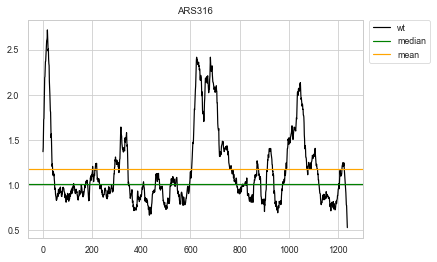

In [158]:
N=30
pooled_wt_smoothed = np.convolve(pooled_wt, np.ones(N)/N, mode="same")

sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = pooled_wt_smoothed, color = "black", label = "wt")
plt.axhline(np.median(pooled_wt_smoothed,axis=0), color ="green", label = "median")
plt.axhline(np.mean(pooled_wt_smoothed,axis=0), color ="orange", label = "mean")
plt.title(load_dir)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0,
          labels = ["wt", "median", "mean"])

In [159]:
significant[(significant["pos_start"]>580)&(significant["pos_start"]<800)]

,pos_start,pos_stop,length,p_value_dies6,p_value_disw2
17,640,679,40,0.001858,0.001464
18,680,719,40,0.011091,0.002955
19,720,759,40,0.000049,0.000070
20,760,799,40,0.000195,0.000055


In [208]:
from scipy import signal

x = pooled_wt_smoothed[500:830]
peaks, properties = signal.find_peaks(x, width=20, 
                               prominence = (0.8, None), 
                               height= np.mean(x)
                              )
properties

{'peak_heights': array([2.4182186]),
 'prominences': array([1.51382471]),
 'left_bases': array([0]),
 'right_bases': array([299]),
 'widths': array([97.53024443]),
 'width_heights': array([1.66130624]),
 'left_ips': array([113.96096369]),
 'right_ips': array([211.49120812])}

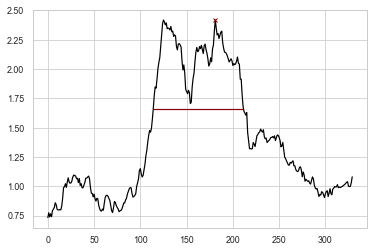

In [209]:
plt.plot(x, color = "black")
plt.plot(peaks, x[peaks], "x", color = "darkred")
plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
            xmax=properties["right_ips"], color = "darkred")

#plt.text(x = properties["left_ips"],y=properties["width_heights"], s = ("width: " + str(int(properties["widths"]))),
#         fontsize = 13, color="darkred")
plt.show()

In [210]:
signal.peak_widths(x, peaks, rel_height = 0.9)[0]

array([180.00514209])

Text(0.5, 1.0, 'Measure peak width at 90% rel height, ARS316')

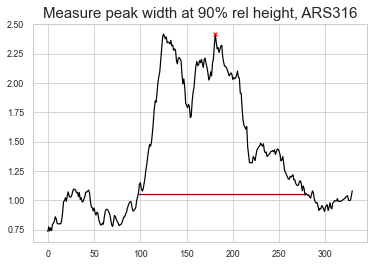

In [211]:
plt.plot(x, color = "black")
plt.plot(peaks, x[peaks], "x", color = "red")
plt.hlines(*signal.peak_widths(x, peaks, rel_height = 0.9)[1:], color ="darkred")
plt.title( "Measure peak width at 90% rel height, ARS316", fontsize = 15)

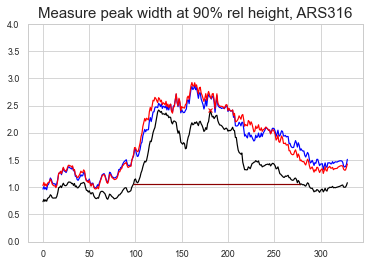

In [223]:
plt.plot(x, color = "black")
plt.plot(np.convolve(pooled_dies6, np.ones(N)/N, mode = "same")[500:830],
         color = "blue")
plt.plot(np.convolve(pooled_disw2, np.ones(N)/N, mode = "same")[500:830],
         color = "red")

plt.plot(peaks, x[peaks], "x", color = "red")
plt.hlines(*signal.peak_widths(x, peaks, rel_height = 0.9)[1:], color ="darkred")
plt.title( "Measure peak width at 90% rel height, ARS316", fontsize = 15)
plt.ylim(0,4)
plt.show()

### Define the width of the nucleosome-free region as P10 - the peak width at 10% of peak height, from the wild type sample. This represents the cutoff for this origin for "nucleosome free"

In [267]:
width = signal.peak_widths(x, peaks, rel_height = 0.9)

In [268]:
pooled_dies6_smoothed = np.convolve(pooled_dies6, np.ones(N)/N, mode = "same")[560:950]
pooled_disw2_smoothed = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same")[560:950]

In [269]:
## If looking at a higher relative peak width, like P20, use a smaller window for mutant strains 
## to measure peak width

#pooled_dies6_smoothed = np.convolve(pooled_dies6, np.ones(N)/N, mode = "same")[580:840]
#pooled_disw2_smoothed = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same")[580:840]

#peak_indices_dies6 = np.where(pooled_dies6_smoothed > width[1])[0]
#width_dies6 = peak_indices_dies6[-1] - peak_indices_dies6[0]
#print("peak width for dies6: ", width_dies6)

#peak_indices_disw2 = np.where(pooled_disw2_smoothed > width[1])[0]
#width_disw2 = peak_indices_disw2[-1] - peak_indices_disw2[0]
#print("peak width for disw2: ", width_disw2)

In [270]:
pooled_dies6_smoothed > width[1] #first 11 values and last 7 values do not belong to the peak

#so peak width =
width_dies6 = len(pooled_dies6_smoothed) -11 -7

In [271]:
#peak_indices_dies6 = np.where(pooled_dies6_smoothed > width[1])[0]
#width_dies6 = peak_indices_dies6[-1] - peak_indices_dies6[0]
print("peak width for dies6: ", width_dies6)

peak width for dies6:  372


In [272]:
pooled_disw2_smoothed > width[1] # first 2 values and last 6 values are not part of the peak
#so peak width = 
width_disw2 = len(pooled_disw2_smoothed) - 8

In [236]:
#peak_indices_disw2 = np.where(pooled_disw2_smoothed > width[1])[0]
#width_disw2 = peak_indices_disw2[-1] - peak_indices_disw2[0]
print("peak width for disw2: ", width_disw2)

peak width for disw2:  382


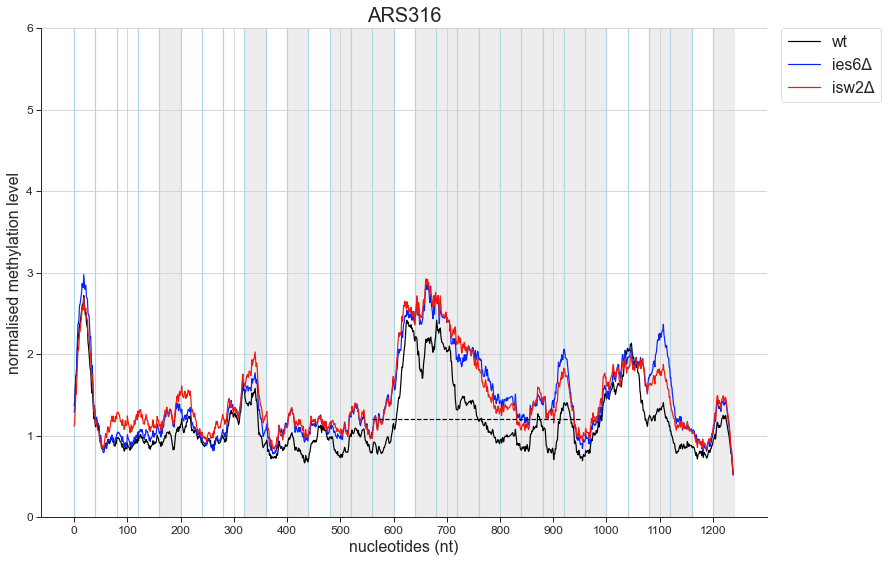

In [244]:
sns.set_context("paper")
#sns.set(style = "whitegrid", font_scale=1.5)
with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False}):

        plt.figure(figsize = (13, 9))
        for left_border in anno.loc[:, "pos_start"]:
            plt.axvline(left_border, color = "lightblue")
        for feature in significant.index:
            plt.fill_betweenx(range(0,7), 
                      significant.loc[feature, "pos_start"],
                      significant.loc[feature, "pos_stop"], 
                      color = "lightgray", alpha = 0.4)
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
             color = "black", 
            label = "wt")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same"), 
             color = "#0a22fa",# alpha = 0.7,
            label = "ies6Δ")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
            y = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same"), 
            color = "#f2180c",# alpha = 0.7,
            label = "isw2Δ")
        plt.title(load_dir , fontsize=20
          #+  ", mean normalised and pooled, smoothened with " + str(N)
                  )
        plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0, fontsize = 16)
        plt.ylim(0, 6)
        plt.xticks(range(0, wt_rep3_minmax.shape[0], 100), fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.xlabel("nucleotides (nt)", fontsize = 16)
        plt.ylabel("normalised methylation level", fontsize = 16)
        
        plt.hlines(y=signal.peak_widths(x, peaks, rel_height = 0.8)[1], # properties["width_heights"],
                   xmin=560 ,#peak_indices_disw2[0]+500,
                   xmax=950, #peak_indices_disw2[-1]+500, 
                   color = "black", linestyles = "dashed")
        
        #plt.savefig(load_dir + "/plots/ARS316_smoothed_profiles_revision_window30_union_selection_peak_width.svg", dpi=300, bbox_inches = "tight")
        plt.show()

## Plot the methylation frequency for the whole sequence of the origin:

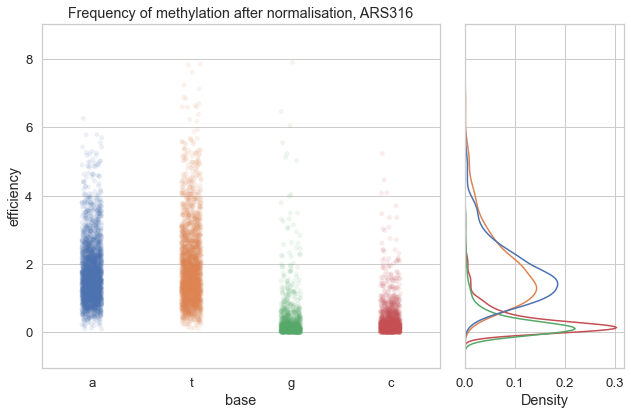

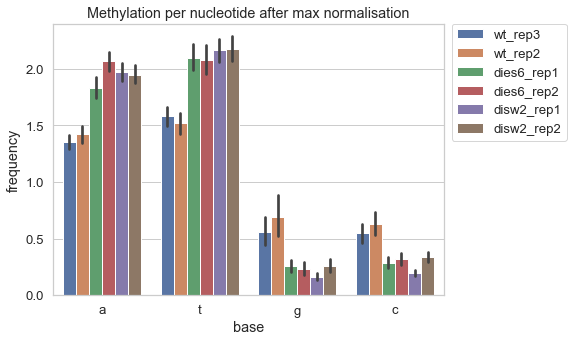

In [218]:
#prepare the data:

seq="atgaaagaatacgttattctttcatcaaatcgtggtcgaccggcatgcaagctccctcgagGTTGTCATCATAATCATACCATTCATTATCCTCTAGTTGGCATGACATTACTTTCCCCGAACTTAGAGAAACTTCAAACGTTATGGTGTCGGGATAAAATTTGATTAATTCACAACCTCTGCAATCAAGGCTTAAAGGAATGAAAGAATCTTCTTTGACCTTCGATAAACCATGCTTCTTCCGCACATCTTTTATCTTGGCCCATTTGTCGTCACTCTGATCAGTTAAATATTCATCCTCAAAAGCGCACAGGTTAACTGACAATTCTTTTGAACAAAATTTACACTTCATCAAGAAAGATGCGGTACCTTTTGATGCCGGCATAGCATATTCTTCAAATGTATTGATGATGACTTTAGAATCGTGTAATTCTCTACAACTGGTACATTGTAGATCGAAGGCAAATTCTGCCCTTGATTCGTTTGTATTCTCAATTGAAACCTTGGTCACGTTTTCTGATAATGTTGCTTTCAGAACCAAAAATAACGGCATTATCGTACACAACCTGGTTTTCTTTATTGGTTAAGTTGTCTTTATTCAAAATTTTTCATTACTTCTTATAAACAGCTTCTTGACGCTTGTAATTTCATAAGTTTTTGATACAAGCAATGGAAACAAAATTAAGAAAATGTAGGCAACGAAGAACTAAATTTGAAAAAAAAAAAAAAAAAAATTTACTGCCAAGATCATCTAAATTATCTTATAGTAGCAAAGCTTGAGCATAAAAGGATCAATCTTTTAGTTTTTTATGGCAAAGTACATTTGCAGTAAGTAATTAGTGATGAGATAAACAAAGAATAATAATCCAATTCGAAATCAAAAATTCAAACAACAAAAAACATAATTTCACATATATATCTAATTCATTCACGAAAAACACGTCAGTTCCTTCTGTCTGTTGTAAATAGGATGCATCCGCAGTGAATCATGGAAATATTTCAAAACTTTCAGCCCAATCATTTTATTTGGTCAATGAAGCCATAAACGCTCCGTAATTCTAAGATTAAAAAAAATTCATAAAAATAAGGACCAATATAAATATATATATTTAATGTGCTAGTGACAATCCTAGTGATAAAATTGCAAATTATACTACAATTGGTCATGGTGAAGCCTAAACACACCATTACGTCTTCACAGTGTTATTCATTTTATTTTCAAAGGTATGCTACTACTAA"
seq=seq.lower()
eff_df = pd.DataFrame({"wt_rep3": wt_rep3_minmax}, index=range(1239))

eff_df["base"] = [letter for letter in seq]
eff_df["wt_rep2"] = wt_rep2_minmax
eff_df["dies6_rep1"] = dies6_rep1_minmax
eff_df["dies6_rep2"] = dies6_rep2_minmax
eff_df["disw2_rep1"] = disw2_rep1_minmax
eff_df["disw2_rep2"] = disw2_rep2_minmax

eff_df_melt = eff_df.melt(id_vars="base", var_name= "sample", value_name="efficiency")

# specify plot layouts with different width using subplots()
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

f, axs = plt.subplots(1,2,
                      figsize=(9,6),
                      sharey=True,
                     gridspec_kw=dict(width_ratios=[2.5,1]))
# make scatterplot with legends
sns.stripplot(data = eff_df_melt, x = "base", y = "efficiency", alpha=0.1, ax= axs[0])
axs[0].set_title("Frequency of methylation after normalisation, ARS316")
axs
# make densityplot with kdeplot without legends
sns.kdeplot(data= eff_df_melt,
                y="efficiency",
                hue="base",
                ax=axs[1],
                legend=False, warn_singular=False)
f.tight_layout()
#plt.savefig(load_dir + "/plots/methylation_efficiency_ARS313.tif", dpi=300)

plt.figure(figsize=(7,5))
sns.barplot(data=eff_df_melt, x = "base", y = "efficiency", hue = "sample")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.title("Methylation per nucleotide after max normalisation")
plt.ylabel("frequency")
#plt.savefig(load_dir + "/plots/methylation_efficiency_naked_plasmid_per_sample.tif", dpi=300, bbox_inches='tight')
plt.show()

In [219]:
#Exporting aggregated data for Anna to plot for the manuscript 
#31th May 2022

smooth = {"wt_pooled": np.convolve(pooled_wt, np.ones(smooth_width)/smooth_width, mode ="same"),
          "wt_rep3": np.convolve(wt_rep3_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
          "wt_rep2": np.convolve(wt_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "dies6_rep1": np.convolve(dies6_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "dies6_rep2": np.convolve(dies6_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "dies6_pooled": np.convolve(pooled_dies6, np.ones(smooth_width)/smooth_width, mode="same"),
         "disw2_rep1": np.convolve(disw2_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "disw2_rep2": np.convolve(disw2_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "disw2_pooled": np.convolve(pooled_disw2, np.ones(smooth_width)/smooth_width, mode="same")}


ARS316_smooth_30 = pd.DataFrame.from_dict(smooth)
ARS316_smooth_30.index = ARS316_smooth_30.index + 1
#ARS316_smooth_30.to_csv("ARS316/ARS316_smoothed_average_methylation_winsize_30.csv")

FC = {
    "dies6_pooled" : np.convolve(pooled_dies6, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
    "disw2_pooled" : np.convolve(pooled_disw2, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same")
}

ARS316_FCs = pd.DataFrame.from_dict(FC)
ARS316_FCs.index = ARS316_FCs.index + 1

#ARS316_FCs.to_csv("ARS316/ARS316_smoothed_fold_changes_winsize_30.csv")